# Recurrent Neural Network for Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

再匯入資料後，將經緯度欄位刪除，然後再計算每兩天間的人數差距，資料從原本的85欄變成81欄，接著再計算各國家間的相關係數，由於原本有185個國家在圖中無法完整呈現，所以我只用了前10個國家來畫圖

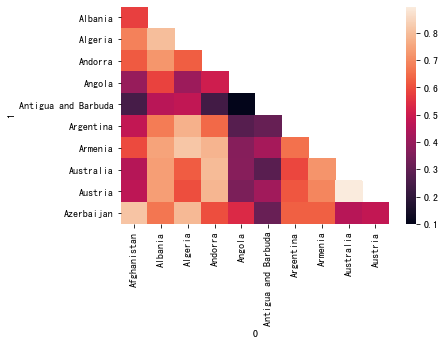

In [2]:
df = pd.read_csv('covid_19.csv')
dff = df.iloc[:,4:].values-df.iloc[:,3:-1].values
df = pd.concat([df.iloc[:,0],pd.DataFrame(dff)],axis=1)
df.index = df['Country/Region']
a = []
for i in range(df.shape[0]-1):
    for j in range(i+1,df.shape[0]):
        cor = np.corrcoef(df.iloc[i,1:].values.astype('float32'), df.iloc[j,1:].values.astype('float32'))[0,1]
        a.append([df.iloc[i,0],df.iloc[j,0],cor])
a = pd.DataFrame(a)
df1= a.pivot(index=1, columns=0, values=2)
sns.heatmap(df1.iloc[:10,:10])

將彼此相關係數大於 0.9的兩個國家都放入C集合中，L設為10，label為人數是否上升，1是上升，0是下降或不變，所以會產生很多長度為10的data，最後在以後20天的資料為test dataset，其餘為train dataset。

In [3]:
a1 = a[a[2]>0.9][0].values
a2 = a[a[2]>0.9][1].values
a3 = np.append(a1,a2)
a4 = np.unique(a3)
data = df.loc[a4,:]
data = data.iloc[:, 1:]
test_data_size = 20
train_data = data.iloc[:,:-test_data_size]
test_data = data.iloc[:,-test_data_size:]

In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [5]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(data.shape[1]-seq_length-1):
        x = data.iloc[:,i:(i+seq_length)].values
        y = data.iloc[:,i+seq_length].values
        xs.append(x)
        yss = []
        for j in range(x.shape[0]): 
            if y[j]>0:
                yss.append(1)
            else:
                yss.append(0)
        ys.append(np.array(yss))
    return np.array(xs), np.array(ys)
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
sample_size = train_data.shape[1]-seq_length-1
sample_size1 = test_data.shape[1]-seq_length-1
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [6]:
X_train = X_train.reshape([sample_size,55,seq_length])
y_train = y_train.reshape([sample_size*55])
X_test = X_test.reshape([sample_size1,55,seq_length])
y_test = y_test.reshape([sample_size1*55])
print(X_train.shape)
print(y_train.size())

torch.Size([50, 55, 10])
torch.Size([2750])


In [18]:
train_on_gpu = torch.cuda.is_available()

In [20]:
class RNN(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(RNN, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.rnn = nn.RNN(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=2)
    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)   # h_state 也要作為 RNN 的一个输入

        outs = []    # 保存所有時間點的预測值
        for time_step in range(r_out.size(1)):    # 對每一個時間點計算 output
            outs.append(self.linear(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state
    
def train_model(model,train_data,train_labels,test_data,test_labels):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimiser = torch.optim.SGD(model.parameters(), lr=0.001)
    num_epochs = 1000
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    h_state = None
    if train_on_gpu: train_data,train_labels,test_data,test_labels = train_data.cuda(),train_labels.cuda(),test_data.cuda(),test_labels.cuda()
    for t in range(num_epochs):
        y_pred ,ss= model(train_data,h_state)
        y_pred = y_pred.reshape([sample_size*55, 2])
        y_pred1 = torch.max(y_pred, 1)[1]
        accuracy = float((y_pred1 == train_labels).sum()) / float(sample_size*55)
        y = train_labels.long()
        lo = loss_fn(y_pred, y)
        with torch.no_grad():
            test_pred ,ss1= model(test_data,h_state)
            test_pred = test_pred.reshape([sample_size1*55,2])
            test_pred1 = torch.max(test_pred, 1)[1]
            accuracy1 = float((test_pred1 == test_labels).sum()) / float(sample_size1*55)
        if t%100 == 0:
            print('Train Epoch: {}/{} Traing_Loss: {:.6f} Traing_acc: {:.6f}% Test_acc: {:.6f}%'.format(t, num_epochs, lo.item(), accuracy*100, accuracy1*100))
        optimiser.zero_grad()
        lo.backward()
        optimiser.step()
        train_hist[t] = accuracy
        test_hist[t] = accuracy1
    return y_pred,train_hist,test_hist

In [21]:
model = RNN(
    n_features=seq_length,
    n_hidden=512,
    seq_len=55,
    n_layers=2
)
if train_on_gpu: model.cuda()
model,train,test = train_model(model, X_train, y_train, X_test, y_test)

Train Epoch: 0/1000 Traing_Loss: 0.708130 Traing_acc: 23.236364% Test_acc: 44.040404%
Train Epoch: 100/1000 Traing_Loss: 0.550924 Traing_acc: 86.581818% Test_acc: 99.393939%
Train Epoch: 200/1000 Traing_Loss: 0.492973 Traing_acc: 86.654545% Test_acc: 99.393939%
Train Epoch: 300/1000 Traing_Loss: 0.450295 Traing_acc: 86.690909% Test_acc: 99.393939%
Train Epoch: 400/1000 Traing_Loss: 0.419120 Traing_acc: 86.072727% Test_acc: 99.393939%
Train Epoch: 500/1000 Traing_Loss: 0.398373 Traing_acc: 86.181818% Test_acc: 99.393939%
Train Epoch: 600/1000 Traing_Loss: 0.385810 Traing_acc: 85.963636% Test_acc: 99.393939%
Train Epoch: 700/1000 Traing_Loss: 0.378497 Traing_acc: 85.818182% Test_acc: 99.393939%
Train Epoch: 800/1000 Traing_Loss: 0.374051 Traing_acc: 85.818182% Test_acc: 99.393939%
Train Epoch: 900/1000 Traing_Loss: 0.371012 Traing_acc: 85.854545% Test_acc: 99.393939%


In [12]:
def plot_result(num_epoch,data):
    epoch = [i for i in range(num_epoch)]
    plt.figure()
    plt.plot(epoch, data)
    plt.xlabel('epoch')
    plt.ylabel('accuracy_rate')
    plt.xticks(range(0,len(train)+1,100))
    plt.title('accuracy_rate')
    plt.show()   

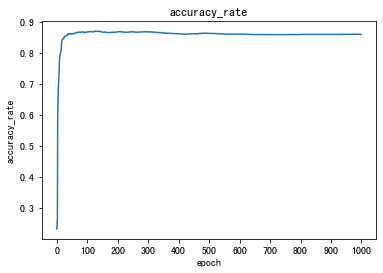

In [22]:
plot_result(1000,train)

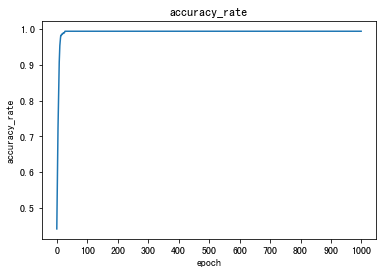

In [23]:
plot_result(1000,test)

# Long Short Term Memory (LSTM)

In [34]:
class lstm(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(lstm, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.5
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=2)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).cuda(),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).cuda()
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)
        y_pred = self.linear(last_time_step)
        return y_pred
    
def train_model(model,train_data,train_labels,test_data,test_labels):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimiser = torch.optim.SGD(model.parameters(), lr=0.001)
    num_epochs = 500
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    if train_on_gpu: train_data,train_labels,test_data,test_labels = train_data.cuda(),train_labels.cuda(),test_data.cuda(),test_labels.cuda()
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(train_data).reshape([sample_size*55, 2])
        y_pred1 = torch.max(y_pred, 1)[1]
        accuracy = float((y_pred1 == train_labels).sum()) / float(sample_size*55)
        y = train_labels.long()
        lo = loss_fn(y_pred, y)
        with torch.no_grad():
            test_pred = model(test_data).reshape([sample_size1*55,2])
            test_pred1 = torch.max(test_pred, 1)[1]
            accuracy1 = float((test_pred1 == test_labels).sum()) / float(sample_size1*55)
            y1 = test_labels.long()
            loss = loss_fn(test_pred, y1)
        if t%100 == 0:
            print('Train Epoch: {}/{} Traing_Loss: {:.6f} Traing_acc: {:.6f}% Test_acc: {:.6f}%'.format(t, num_epochs, lo.item(), accuracy*100, accuracy1*100))
        optimiser.zero_grad()
        lo.backward()
        optimiser.step()
        train_hist[t] = accuracy
        test_hist[t] = accuracy1
    return y_pred,train_hist,test_hist

In [26]:
train_on_gpu

True

In [35]:
model = lstm(
    n_features=seq_length,
    n_hidden=512,
    seq_len=55,
    n_layers=2
)
if train_on_gpu: model.cuda()
model,train,test = train_model(model, X_train, y_train, X_test, y_test)

Train Epoch: 0/500 Traing_Loss: 0.689659 Traing_acc: 65.818182% Test_acc: 28.888889%
Train Epoch: 100/500 Traing_Loss: 0.664850 Traing_acc: 79.672727% Test_acc: 96.161616%
Train Epoch: 200/500 Traing_Loss: 0.645706 Traing_acc: 81.636364% Test_acc: 98.585859%
Train Epoch: 300/500 Traing_Loss: 0.627824 Traing_acc: 82.436364% Test_acc: 98.181818%
Train Epoch: 400/500 Traing_Loss: 0.612332 Traing_acc: 82.763636% Test_acc: 98.181818%


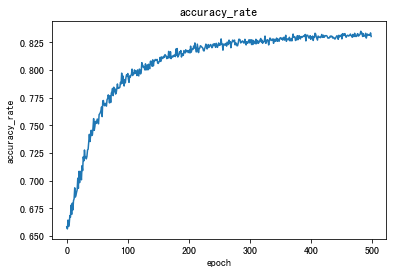

In [36]:
plot_result(500,train)

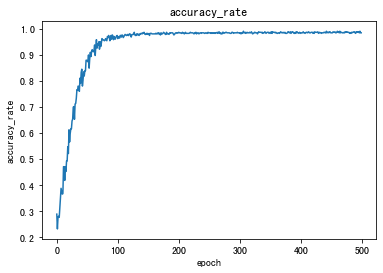

In [37]:
plot_result(500,test)

In [39]:
predi =  model.reshape([50,55,2])[-1].cpu()
label = torch.max(predi, 1)[1]
predi = predi.data.numpy()
predi = 1 / (1 + np.exp(-predi.max(axis = 1)))
countrys = np.array(train_data.index)

In [49]:
import pygal_maps_world.maps
from pygal_maps_world.maps import COUNTRIES

def get_country_code(country_name):
    for code, name in COUNTRIES.items():
        if name == country_name:
            return code
    return None

country_symb=[]
for i in countrys:
    country_symb.append(get_country_code(i))
al=pd.Series(predi.reshape(-1))
al.index=country_symb
al=al[al.index.notnull()]

up=al[al>=0.5]
down=al[al<0.5]
    
up=up.to_dict()
down=down.to_dict()

worldmap_chart = pygal_maps_world.maps.World()

worldmap_chart.add("ascending", up)
worldmap_chart.add("descending", down)
worldmap_chart.render_to_file('bar_chart.svg')